# Import Libraries 

In [146]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import golden
from scipy.optimize import fminbound
from scipy.optimize import minimize
from scipy.linalg import svd
from scipy.stats import trim_mean
import scipy.io
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import os
import functools
import csv

In [147]:
run_number = 78 #Options: 78,79,80,81,82,83,86

In [148]:
TI_log_array = (np.logspace(0,np.log10(2000),12)+.5)//1#Upper will be referred to as the second point

In [149]:
T22 = 40.7 #+- 0.2 ms
T12 = 353.3 #+- 12.6 ms
c2 = 0.55

#Upper will be referred to as the first point
T21 = 30.8 #+- 0.2 ms
T11 = 91.5 #+- 2.3 ms
c1 = 0.5
c2 = 1 - c1

true_params = [T11, T12, c1, c2, T21, T22]

#### Nullpoint Values
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

ParamTitle_6p = [r'$T_{11}$', r'$T_{12}$', r'$c_1$', r'$c_2$', r'$T_{21}$', r'$T_{22}$']

print(f'Null Point 1 = {TI1star: .2f}')
print(f'Null Point 2 = {TI2star: .2f}')

Null Point 1 =  63.42
Null Point 2 =  244.89


In [150]:
#Phased is a matrix of 64 TI trials. Each TI trial has 100 noise realizations with 2048 echos

cwd = os.getcwd()

file_oi = f"real_phased_run{run_number}" #imag_unphased_dataset    real_unphased_dataset   real_phased_dataset

raw = scipy.io.loadmat(f'{cwd}/{file_oi}.mat')
raw_complex = raw['real_phased_dataset']

with open(f'{cwd}\\dualGel_TI.txt') as f:
    TI = f.readlines()
TI_DATA = [int(sub.replace("\n", "")) for sub in TI]

assert(TI_DATA[0] < TI_DATA[-1])
TE_DATA = np.arange(1,2048.1,1)*0.4 #ms

In [151]:
print(TI_log_array)
TI_log_array_indices = [np.where(iTI == TI_DATA)[0][0] for iTI in TI_log_array]
print(f"TI indices = {TI_log_array_indices}")
print(f"TI values = {[TI_DATA[iTI] for iTI in TI_log_array_indices]} ms")

[1.000e+00 2.000e+00 4.000e+00 8.000e+00 1.600e+01 3.200e+01 6.300e+01
 1.260e+02 2.520e+02 5.020e+02 1.002e+03 2.000e+03]
TI indices = [0, 1, 2, 3, 4, 5, 16, 27, 72, 103, 104, 105]
TI values = [1, 2, 4, 8, 16, 32, 63, 126, 252, 502, 1002, 2000] ms


# Options

In [152]:
normalize_data = True
random_start = False
full_plot = False
early_subset = True
introduce_offset = True
TI_subset = True

imag_opt = False

In [153]:
sp = 2
ext = 256
if early_subset:
    raw_complex = raw_complex[sp-1::sp,:,:]
    TE_DATA = TE_DATA[sp-1::sp]
    raw_complex = raw_complex[:ext,:,:]
    TE_DATA = TE_DATA[:ext]

raw_real = np.real(raw_complex)
raw_imag = np.imag(raw_complex)

multi_start_obj = 1

if imag_opt:
    raw_data = raw_imag
else:
    raw_data = raw_real

noise_realizations = raw_data.shape[-1]
assert(len(TI_DATA) == raw_data.shape[1])
print(f"Raw Data has shape {raw_data.shape}")
print(f"TE values = [{TE_DATA[0]}, {TE_DATA[1]}, {TE_DATA[2]}, ..., {TE_DATA[-1]}]")
print(f"TI values = [{TI_DATA[0]}, {TI_DATA[1]}, {TI_DATA[2]}, ..., {TI_DATA[-1]}]")


Raw Data has shape (256, 106, 99)
TE values = [0.8, 1.6, 2.4000000000000004, ..., 204.8]
TI values = [1, 2, 4, ..., 2000]


# Define Functions

In [154]:
def S_biX_6p(TE, T11, T12, c1, c2, T21, T22, TI = 0):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#The ravel structure necessary for the curve_fit algorithm
def S_biX_6p_ravel(T_dat, T11, T12, c1, c2, T21, T22):
    TE, TI = T_dat
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2


def get_func_bounds(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        lower_bound = (1, 1, 0, 0, 1, 1)
        upper_bound = (500, 500, 1, 1, 150, 150)
    elif f_name == "S_moX_3p":
        lower_bound = (1, 0, 1)
        upper_bound = (500, 1, 150)
    elif f_name == "S_biX_4p":
        lower_bound = (-1, -1, 1, 1)
        upper_bound = (1, 1, 150, 150)
    elif f_name == "S_moX_2p":
        lower_bound = (-1, 1)
        upper_bound = (1, 150)
    else:
        raise Exception("Not a valid function: " + f_name)

    return lower_bound, upper_bound

def get_param_list(func):
    f_name = func.__name__
    if f_name.find("S_biX_6p") > -1:
        params = ("T21","T22","c1","c2","T21","T22")
    elif f_name.find("S_moX_3p") > -1:
        params = ("T21","c","T2")
    else:
        raise Exception("Not a valid function: " + f_name)

    return params

def set_p0(func, random = True):
    # true_params = [T11, T12, c1, c2, T21, T22]
    if random:
        lb, ub = get_func_bounds(func)
        if func.__name__.find("S_biX_6p") > -1:
            T11_est = np.random.uniform(lb[-6],ub[-6])
            T12_est = np.random.uniform(T11_est,ub[-5])
            c1_est = np.random.uniform(lb[-4],ub[-4])
            T21_est = np.random.uniform(lb[-2],ub[-2])
            T22_est = np.random.uniform(T21_est,ub[-1])
            p0 = [T11_est, T12_est, c1_est, 1-c1_est, T21_est, T22_est]
        else:
            p0 = [np.random.uniform(lb[i],ub[i]) for i in range(len(lb))]
    else:
        p0 = true_params
            
    return p0


def det_normFactor(noisy_curve):

    lb = (0, 0, 0, 0)
    ub = (np.inf, np.inf, 150, 150)

    d_init = 0.5*noisy_curve[0]

    popt, _, _, _, _ = curve_fit(S_biX_4p, TE_DATA, noisy_curve, p0 = (d_init, d_init, 30, 50), bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output=True)

    return popt[0]+popt[1]

def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

In [155]:
def calc_MSE(iteration_param_values, true_p):

    bias_values = np.mean(iteration_param_values - true_p, axis = 0)
    std_values = np.std(iteration_param_values, axis = 0)
    MSE_values = std_values**2 + bias_values**2

    return bias_values, std_values, MSE_values

def calc_SNR(noisy_curve):
    return noisy_curve[0]/np.mean(noisy_curve[-3:])


In [156]:
def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def estP_oneCurve(func, noisey_data, T_DATA):

    lb, ub = get_func_bounds(func)

    RSS = np.inf
    for iMS in range(multi_start_obj):
        init_p = set_p0(func, random = random_start)
        temp_popt, _, info, _, _ = curve_fit(func, T_DATA, noisey_data, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output = True)
        RSS_temp = np.sum(info['fvec']**2)
        if RSS_temp < RSS:
            RSS = RSS_temp
            popt = check_param_order(temp_popt)

    return popt, RSS


# Initial Visualization

(0.0, 300.0)

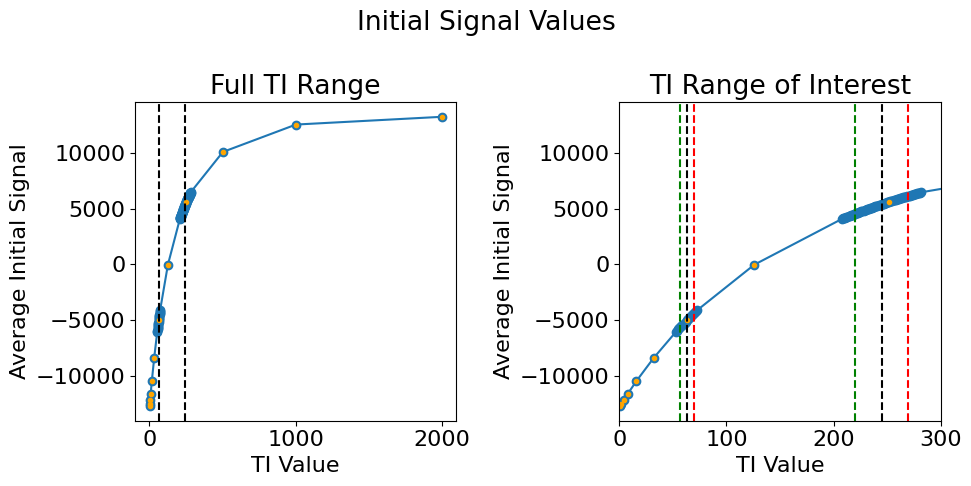

In [157]:
plt.rc('font', size = 16)
fig, ax = plt.subplots(1,2, figsize = (10, 5), tight_layout=True)

fig.suptitle(f"Initial Signal Values")

ax[0].set_title("Full TI Range")
ax[0].plot(TI_DATA, np.mean(raw_data[0,:,:], axis = -1), marker = 'o')
[ax[0].plot(TI_DATA[iTI], np.mean(raw_data[0,iTI,:], axis = -1), marker = 'o', ls = '', markersize = 3, color = 'orange') for iTI in TI_log_array_indices]

ax[0].set_ylabel("Average Initial Signal")
ax[0].set_xlabel("TI Value")

ax[0].axvline(x = TI1star, ls = '--', color = 'k')
ax[0].axvline(x = TI2star, ls = '--', color = 'k')
# fig.legend(loc = 'center left', bbox_to_anchor = (1.02,0.4))

ax[1].set_title("TI Range of Interest")
ax[1].plot(TI_DATA, np.mean(raw_data[0,:,:], axis = -1), marker = 'o')
[ax[1].plot(TI_DATA[iTI], np.mean(raw_data[0,iTI,:], axis = -1), marker = 'o', ls = '', markersize = 3, color = 'orange') for iTI in TI_log_array_indices]

ax[1].set_ylabel("Average Initial Signal")
ax[1].set_xlabel("TI Value")

ax[1].axvline(x = TI1star, ls = '--', color = 'k')
ax[1].axvline(x = TI2star, ls = '--', color = 'k')

ax[1].axvline(x = 0.9*TI1star, ls = '--', color = 'g')
ax[1].axvline(x = 0.9*TI2star, ls = '--', color = 'g')

ax[1].axvline(x = 1.1*TI1star, ls = '--', color = 'r')
ax[1].axvline(x = 1.1*TI2star, ls = '--', color = 'r')


ax[1].set_xlim([0,300])

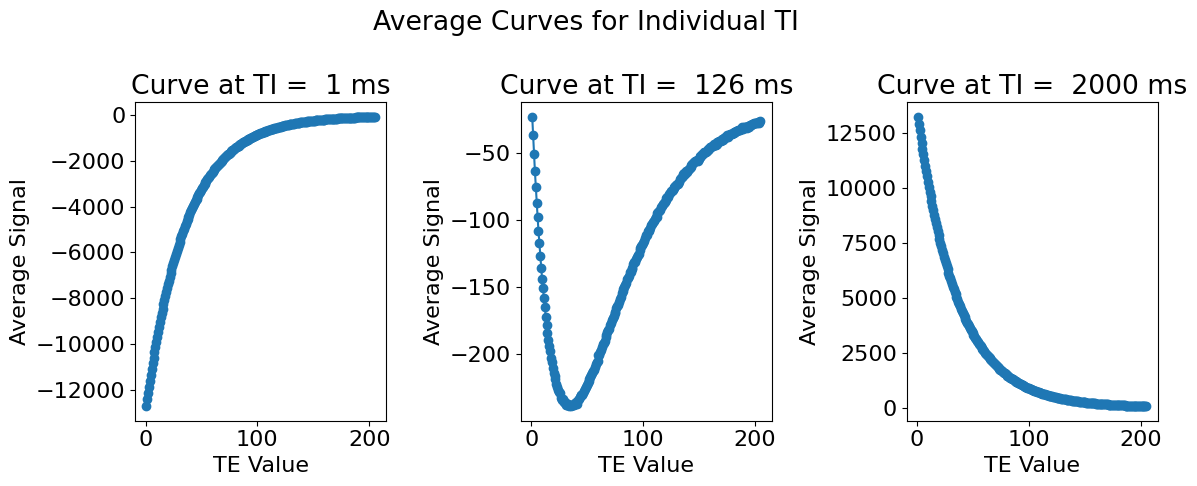

In [158]:
indices = [0,27,-1]

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,3, figsize = (12, 5), tight_layout=True)

fig.suptitle(f"Average Curves for Individual TI")

for i in range(len(indices)):
    index_oi = indices[i]
    ax[i].set_title(f"Curve at TI = {TI_DATA[index_oi]: .0f} ms")
    ax[i].plot(TE_DATA, np.mean(raw_data[:,index_oi,:], axis = -1), marker = 'o')

    ax[i].set_ylabel("Average Signal")
    ax[i].set_xlabel("TE Value")


# Checking Curve Shape with Model

Text(0.5, 0, 'TE Value')

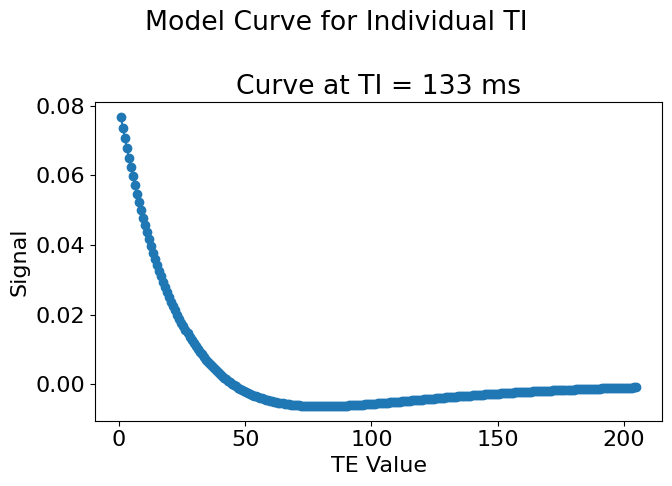

In [159]:
TI_funky = 133

data_temp = S_biX_6p(TE_DATA, *true_params, TI = TI_funky)

plt.rc('font', size = 16)
fig, ax = plt.subplots(1,1, figsize = (7, 5), tight_layout=True)

fig.suptitle(f"Model Curve for Individual TI")

ax.set_title(f"Curve at TI = {TI_funky} ms")
ax.plot(TE_DATA, data_temp, marker = 'o')

ax.set_ylabel("Signal")
ax.set_xlabel("TE Value")

# SNR Calculation

Average Value = 166.66


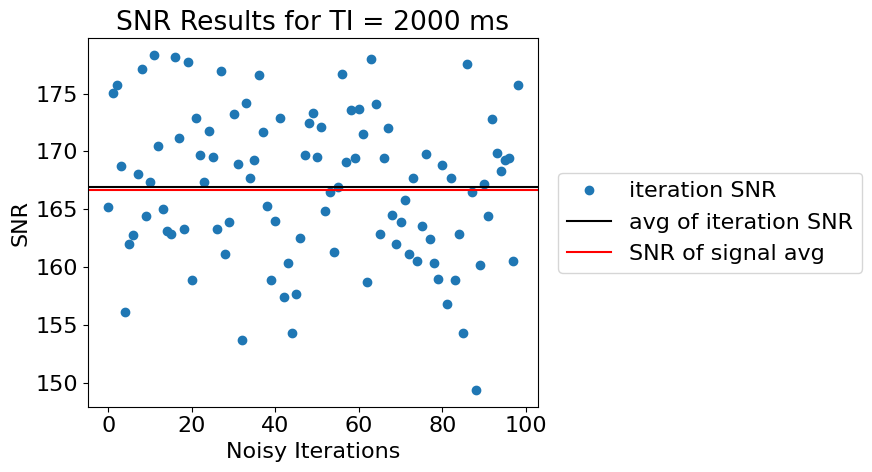

In [160]:
iterSNR = [calc_SNR(raw_data[:,-1,i]) for i in range(raw_data.shape[-1])]
avgSNR = calc_SNR(np.mean(raw_data[:,-1,:], axis = -1))

fig, ax = plt.subplots(1,1, figsize = (9, 5), tight_layout=True)

ax.set_title(f"SNR Results for TI = {TI_DATA[-1]} ms")
ax.plot(range(raw_data.shape[-1]), iterSNR, marker = 'o', ls = '', label = "iteration SNR")
ax.axhline(y = np.mean(iterSNR), color = 'k', label = 'avg of iteration SNR')
ax.axhline(y = avgSNR, color = 'r', label = 'SNR of signal avg')

ax.set_ylabel("SNR")
ax.set_xlabel("Noisy Iterations")

ax.legend(loc = 'center left', bbox_to_anchor = (1.02,0.5))
print(f'Average Value = {avgSNR :.2f}')

# Preprocessing

In [161]:
if normalize_data:
    norm_factor = det_normFactor(np.mean(raw_data[:,-1,:], axis = -1))
    normed_data = raw_data/norm_factor
    print(f"All data has been normalized by the normalization factor value of {norm_factor: 0.2f}")
else:
    print("No Normalization")
    normed_data = raw_data

All data has been normalized by the normalization factor value of  13529.86


# Estimating

In [162]:
mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)
vecT = np.vstack((mTE.ravel(), mTI.ravel()))

param_iters_conven = np.zeros((raw_data.shape[-1],6))
param_iters_RSS = np.zeros((raw_data.shape[-1]))

avg_normed_data = np.mean(normed_data, axis = -1)

vecS = np.transpose(avg_normed_data).ravel()

param_avgSig_conven, RSS_avgSig_conven = estP_oneCurve(S_biX_6p_ravel, vecS, vecT)

print(f"Param Estimates")
[print(f'{elem:.2f}') for elem in param_avgSig_conven]
print(f"RSS = {RSS_avgSig_conven}")
print(f"Param Error")
[print(f'{elem:.2f}') for elem in (param_avgSig_conven-true_params)]

for i in trange(raw_data.shape[-1]):
    vecS = np.transpose(normed_data[:,:,i]).ravel()
    temp_popt, temp_RSS = estP_oneCurve(S_biX_6p_ravel, vecS, vecT)

    param_iters_conven[i,:] = temp_popt
    param_iters_RSS[i] = temp_RSS

Param Estimates
98.38
297.87
0.41
0.57
29.97
40.41
RSS = 0.037232199521160775
Param Error
6.88
-55.43
-0.09
0.07
-0.83
-0.29


100%|██████████| 99/99 [00:33<00:00,  2.99it/s]


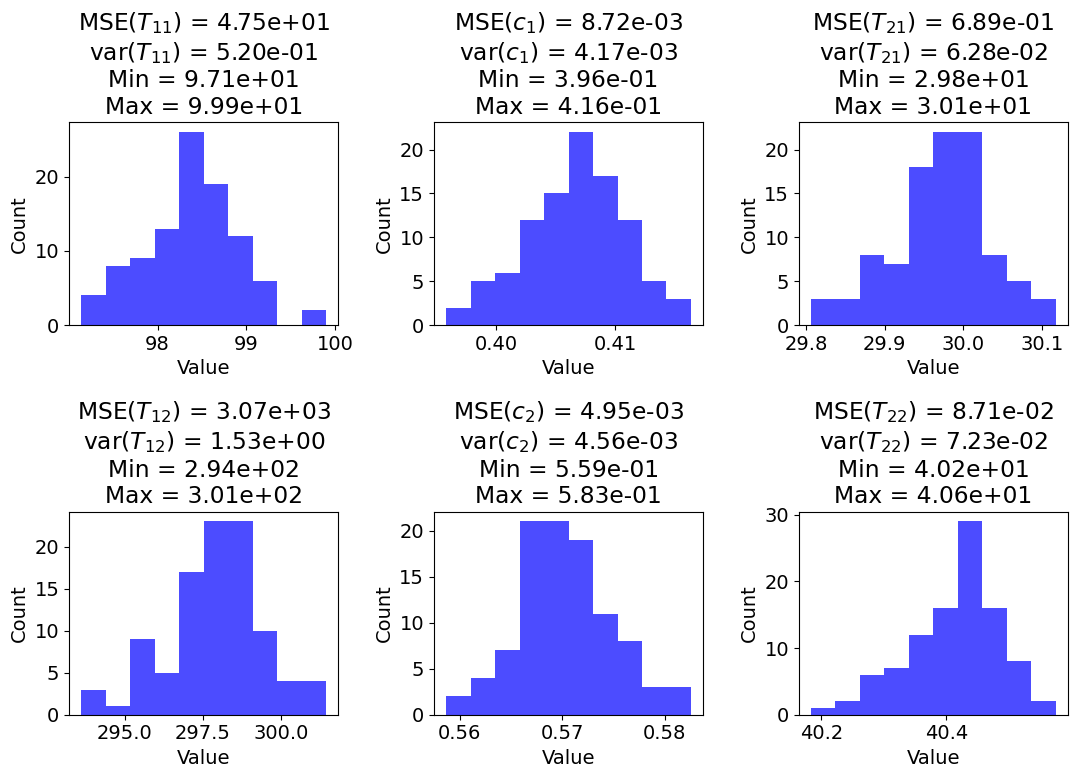

In [163]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(11, 8), tight_layout=True)
# fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")


biasMat, stdMat, MSEMat = calc_MSE(param_iters_conven, true_params)

for i in range(param_iters_conven.shape[-1]):

    # bin_array = np.arange(0, 1, 0.01)
    ax[i%2, i//2].hist(x=param_iters_conven[:,i], color='b', alpha = 0.7)
    # ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
    ax[i%2, i//2].set_xlabel('Value')
    ax[i%2, i//2].set_ylabel('Count')
    ax[i%2, i//2].set_title(f"MSE({ParamTitle_6p[i]}) = {MSEMat[i]:.2e}\nvar({ParamTitle_6p[i]}) = {stdMat[i]:.2e}\nMin = {np.min(param_iters_conven[:,i]):.2e}\nMax = {np.max(param_iters_conven[:,i]):.2e}")

    ymin, ymax = ax[i%2, i//2].get_ylim()
    xmin, xmax = ax[i%2, i//2].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

# Visualizing Surface and Fits

(106, 256)
(256, 106)


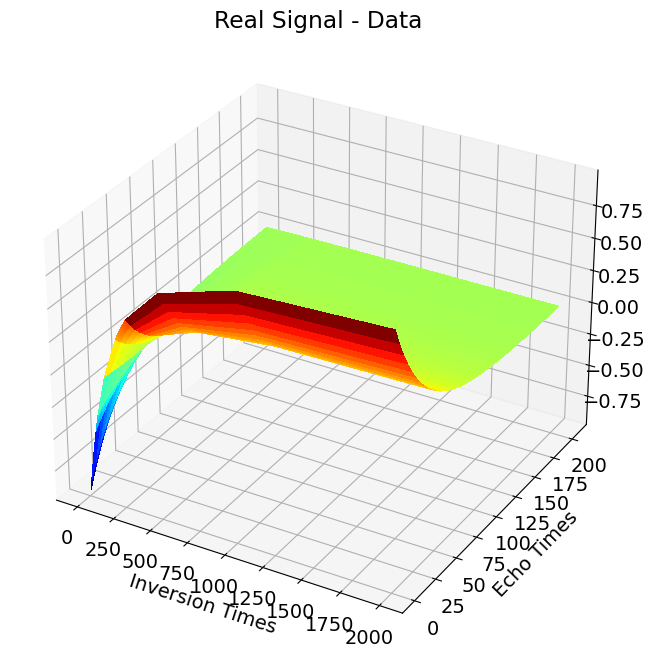

In [164]:
#### Actual Data Surface

print(mTI.shape)
print(avg_normed_data.shape)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, np.transpose(avg_normed_data), cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Real Signal - Data')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

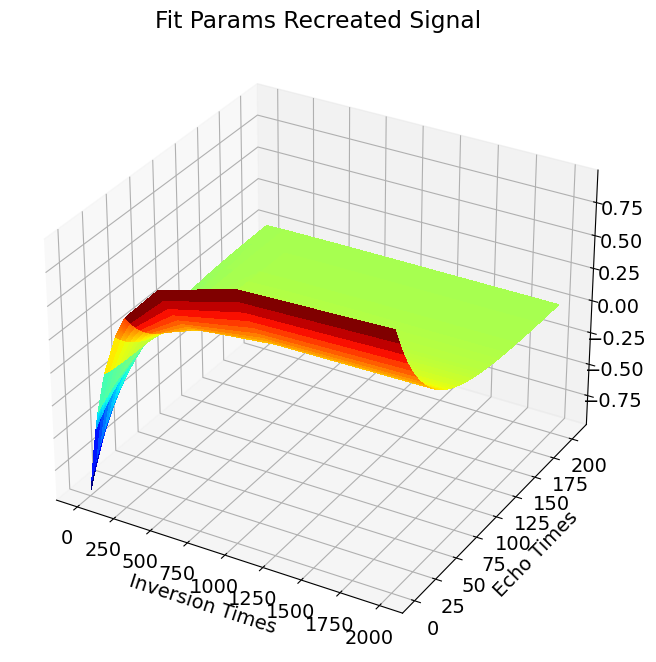

In [165]:
#### Actual Data Surface

recreated_sig = S_biX_6p(mTE, *param_avgSig_conven, TI = mTI)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, recreated_sig, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Fit Params Recreated Signal')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

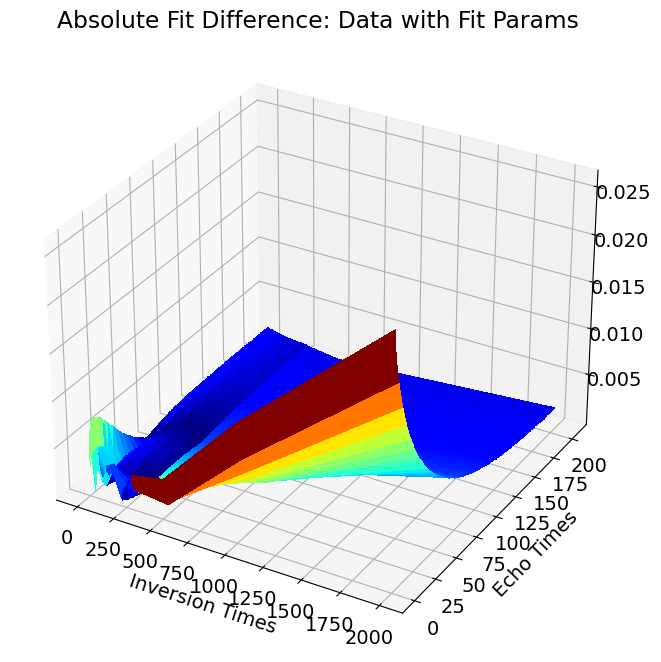

In [166]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, np.abs(recreated_sig - np.transpose(avg_normed_data)), cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Absolute Fit Difference: Data with Fit Params')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

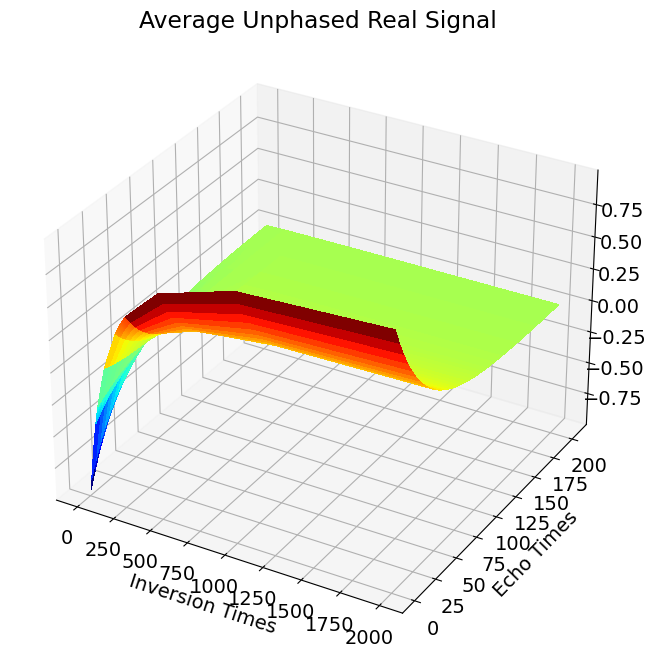

In [167]:
#### Actual Data Surface

recreated_sig_true = S_biX_6p(mTE, *true_params, TI = mTI)

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, recreated_sig_true, cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Average Unphased Real Signal')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

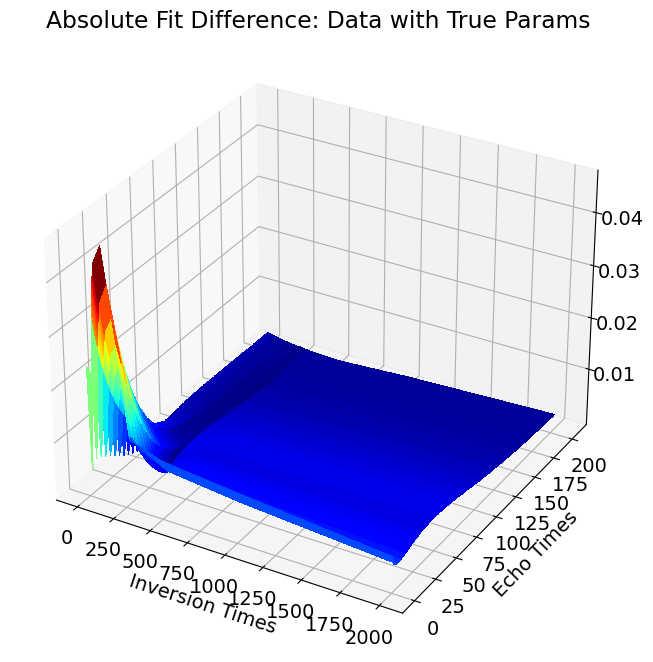

In [168]:
#### Actual Data Surface
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(mTI, mTE, np.abs(recreated_sig_true - np.transpose(avg_normed_data)), cmap = plt.cm.jet, linewidth=0, antialiased=False)

ax.set_title('Absolute Fit Difference: Data with True Params')
ax.set_xlabel('Inversion Times')
ax.set_ylabel('Echo Times')
ax.view_init(30, )
plt.show()

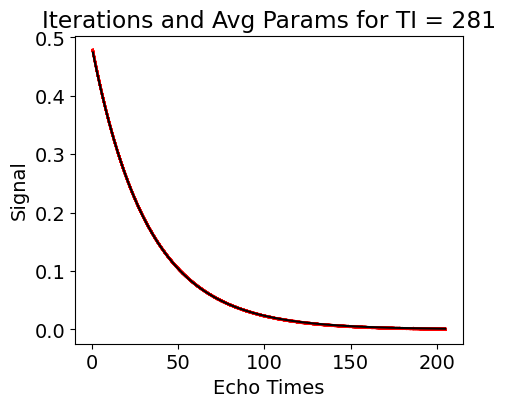

In [169]:
index_TI = -5

fig, ax = plt.subplots(1,1, figsize = (5,4))

TI_oi = TI_DATA[index_TI]

for i in range(normed_data.shape[-1]):
    ax.plot(TE_DATA, normed_data[:,index_TI, i], color = 'r')
    
ax.plot(TE_DATA, S_biX_6p(TE_DATA, *param_avgSig_conven, TI = TI_oi), color = 'k')

ax.set_title(f'Iterations and Avg Params for TI = {TI_oi}')
ax.set_xlabel('Echo Times')
ax.set_ylabel('Signal')
plt.show()

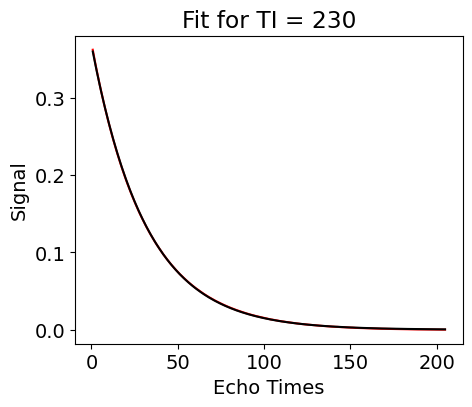

In [170]:
index_TI = 50

TI_oi = TI_DATA[index_TI]

lb, ub = get_func_bounds(S_biX_6p)

RSS = np.inf
for iMS in range(multi_start_obj):
    init_p = set_p0(S_biX_6p, random = random_start)
    temp_popt, _, info, _, _ = curve_fit(functools.partial(S_biX_6p, TI = TI_DATA[index_TI]), TE_DATA, avg_normed_data[:,index_TI], p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500, full_output = True)
    RSS_temp = np.sum(info['fvec']**2)
    if RSS_temp < RSS:
        RSS = RSS_temp
        popt = check_param_order(temp_popt)

fig, ax = plt.subplots(1,1, figsize = (5,4))

TI_oi = TI_DATA[index_TI]

ax.plot(TE_DATA, avg_normed_data[:,index_TI], color = 'r')
    
ax.plot(TE_DATA, S_biX_6p(TE_DATA, *popt, TI = TI_DATA[index_TI]), color = 'k')

ax.set_title(f'Fit for TI = {TI_oi}')
ax.set_xlabel('Echo Times')
ax.set_ylabel('Signal')
plt.show()

In [171]:
lb, ub = get_func_bounds(S_biX_6p)
popt_array = np.zeros((len(TI_DATA), 6))
RSS_array = np.zeros(len(TI_DATA))

for iTI in trange(len(TI_DATA)):

    RSS = np.inf
    for iMS in range(multi_start_obj):
        init_p = set_p0(S_biX_6p, random = random_start)
        temp_popt, _, info, _, _ = curve_fit(functools.partial(S_biX_6p, TI = TI_DATA[iTI]), TE_DATA, avg_normed_data[:,iTI], p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 4000, full_output = True)
        RSS_temp = np.sum(info['fvec']**2)
        if RSS_temp < RSS:
            RSS = RSS_temp
            popt = check_param_order(temp_popt)

    popt_array[iTI,:] = popt
    RSS_array[iTI] = RSS



100%|██████████| 106/106 [00:14<00:00,  7.28it/s]


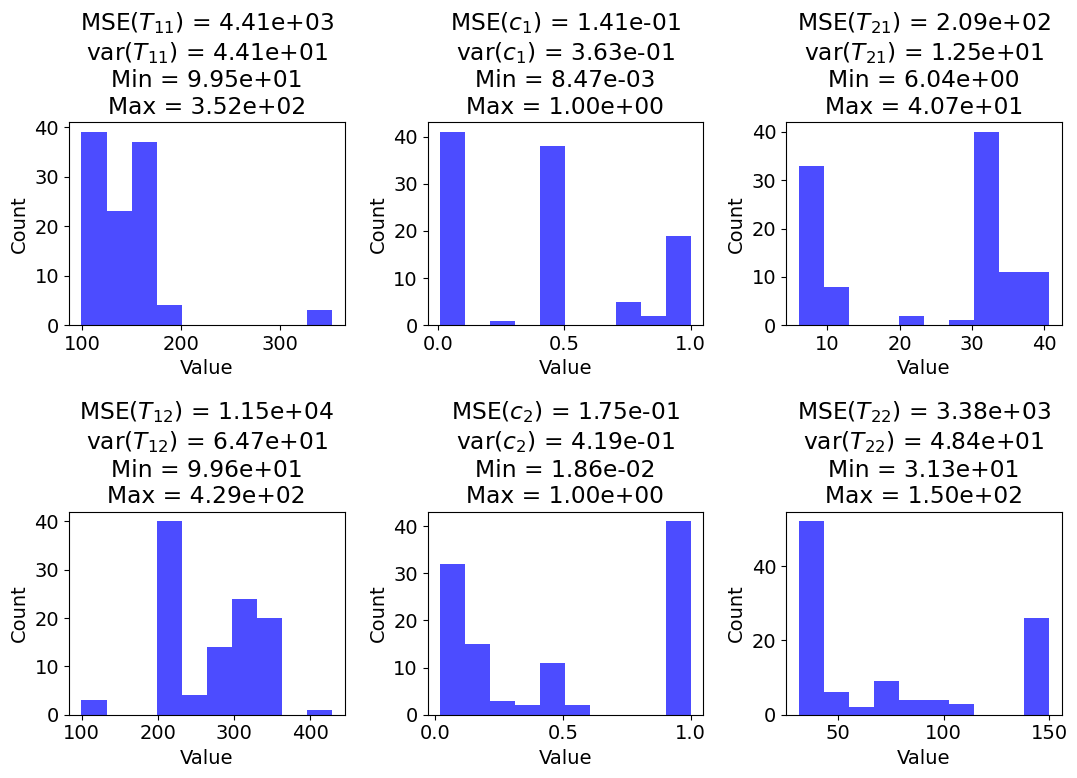

In [172]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(11, 8), tight_layout=True)
# fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")

biasMat, stdMat, MSEMat = calc_MSE(popt_array, true_params)

for i in range(popt_array.shape[-1]):

    # bin_array = np.arange(0, 1, 0.01)
    ax[i%2, i//2].hist(x=popt_array[:,i], color='b', alpha = 0.7)
    # ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
    ax[i%2, i//2].set_xlabel('Value')
    ax[i%2, i//2].set_ylabel('Count')
    ax[i%2, i//2].set_title(f"MSE({ParamTitle_6p[i]}) = {MSEMat[i]:.2e}\nvar({ParamTitle_6p[i]}) = {stdMat[i]:.2e}\nMin = {np.min(popt_array[:,i]):.2e}\nMax = {np.max(popt_array[:,i]):.2e}")

    ymin, ymax = ax[i%2, i//2].get_ylim()
    xmin, xmax = ax[i%2, i//2].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

Text(0, 0.5, 'Count')

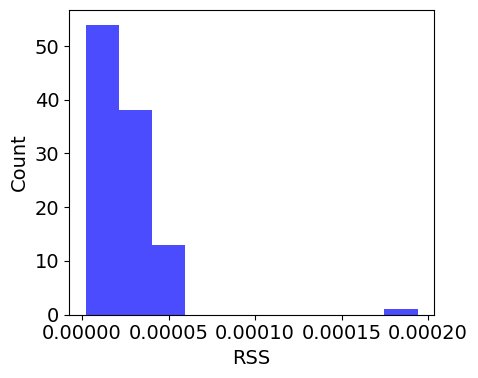

In [173]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(1,1, figsize=(5, 4), tight_layout=True)
# fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")

ax.hist(x=RSS_array, color='b', alpha = 0.7)
# ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
ax.set_xlabel('RSS')
ax.set_ylabel('Count')

# Simulating Experiment

In [174]:
TI_DATA_simExp = np.array(TI_DATA)[TI_log_array_indices]
normed_data_simExp = normed_data[:,TI_log_array_indices,:]

noise_realizations = normed_data_simExp.shape[-1]
assert(len(TI_DATA_simExp) == normed_data_simExp.shape[1])
print(f"Raw Data has shape {normed_data_simExp.shape}")
print(f"TE values = [{TE_DATA[0]}, {TE_DATA[1]}, {TE_DATA[2]}, ..., {TE_DATA[-1]}]")
print(f"TI values = [{TI_DATA[0]}, {TI_DATA[1]}, {TI_DATA[2]}, ..., {TI_DATA[-1]}]")

Raw Data has shape (256, 12, 99)
TE values = [0.8, 1.6, 2.4000000000000004, ..., 204.8]
TI values = [1, 2, 4, ..., 2000]


In [175]:
COFFEE_TI1_index = np.argmin((TI_DATA_simExp - TI1star)**2)
print(f"Index of TI1* TI = {COFFEE_TI1_index}")
print(f"Absolute Percent Difference from TI1* = {np.abs(TI1star - TI_DATA_simExp[COFFEE_TI1_index])/TI1star*100:.2f}%")

Index of TI1* TI = 6
Absolute Percent Difference from TI1* = 0.67%


In [176]:
COFFEE_TI2_index = np.argmin((TI_DATA_simExp - TI2star)**2)
print(f"Index of TI2* TI = {COFFEE_TI2_index}")
print(f"Absolute Percent Difference from TI2* = {np.abs(TI2star - TI_DATA_simExp[COFFEE_TI2_index])/TI2star*100:.2f}%")

Index of TI2* TI = 8
Absolute Percent Difference from TI2* = 2.90%


In [177]:
multi_starts_obj = 1
randStart = False

In [178]:
def S_moX_3p(TE, T1, c, T2, TI = 0):
    return c*(1-2*np.exp(-TI/T1))*np.exp(-TE/T2)

def calculate_RSS_TI(func, popt, TI_val, data):
    est_curve = func(TE_DATA, *popt, TI = TI_val)
    RSS = np.sum((est_curve - data)**2)
    
    return RSS

def bounds_condensed(lb, ub):
    lb, ub = get_func_bounds(S_biX_6p)
    bnd_cat = [lb,ub]
    bnd_cat = np.array(bnd_cat)
    bnd_cat = np.transpose(bnd_cat)
    bnds = bnd_cat.tolist()
    return bnds

def list_objective_func(param_est, data_2d, TI_array, X_list):
    assert(data_2d.shape[0] == len(TI_array))
    assert(len(X_list) == len(TI_array))

    curve_RSS = 0

    X_truth = [elem == "BiX" for elem in X_list]

    for iter in range(len(X_truth)):
        if X_truth[iter]:
            RSS_add = calculate_RSS_TI(S_biX_6p, param_est, TI_array[iter], data_2d[iter,:])
        else:
            if data_2d[iter,0] < 0:
                #first null point -> that means that only the long parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-5], param_est[-3], param_est[-1]], TI_array[iter], data_2d[iter,:])
            else:
                #second null point -> that means that only the short parameters with the two are used
                RSS_add = calculate_RSS_TI(S_moX_3p, [param_est[-6], param_est[-4], param_est[-2]], TI_array[iter], data_2d[iter,:])

        curve_RSS += RSS_add

    return curve_RSS

def preEstimate_parameters(TE_DATA, TI_DATA, noised_data, lb, ub):

    mTE, mTI = np.meshgrid(TE_DATA, TI_DATA)
    vecT = np.vstack((mTE.ravel(), mTI.ravel())) #flattens the data points

    cF_fval = np.inf

    no_opt_found = 0

    for ms_iter in range(multi_starts_obj):
        init_p = set_p0(S_biX_6p, random = randStart)

        try:
            vecS = noised_data.ravel()
            popt_temp, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 5000)
            RSS_cF_array = []
            for iter in range(noised_data.shape[0]):
                RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt_temp, TI_DATA[iter], noised_data[iter,:]))
            RSS_cF_temp = np.sum(RSS_cF_array)
            if RSS_cF_temp < cF_fval:
                popt = popt_temp
                cF_fval = RSS_cF_temp
        except:
            no_opt_found+=1

    #This is the failsafe to ensure that some parameters are found
    if no_opt_found == multi_starts_obj:
        print("Overtime")
        while no_opt_found > 0:
            init_p = set_p0(S_biX_6p, random = randStart)
            try:
                vecS = noised_data.ravel()
                popt_temp, _ = curve_fit(S_biX_6p_ravel, vecT, vecS, p0 = init_p, bounds = [lb, ub], method = 'trf', maxfev = 5000)
                RSS_cF_array = []
                for iter in range(noised_data.shape[0]):
                    RSS_cF_array.append(calculate_RSS_TI(S_biX_6p, popt_temp, TI_DATA[iter], noised_data[iter,:]))
                RSS_cF_temp = np.sum(RSS_cF_array)
                if RSS_cF_temp < cF_fval:
                    popt = popt_temp
                    cF_fval = RSS_cF_temp
                no_opt_found = 0
            except:
                no_opt_found = 1

    return check_param_order(popt)


def estimate_parameters(popt, TI_DATA, noised_data, lb, ub, list_curve_X, list_curve_cvn):

    bnds = bounds_condensed(lb, ub)

    res_COFFEE = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_X), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})
    res_cvn = minimize(list_objective_func, popt, args = (noised_data, TI_DATA, list_curve_cvn), method = 'Nelder-Mead', bounds = bnds, options = {'maxiter': 4000, 'disp': False})

    #Pulling relevant AIC objective function parts
    param_est_COFFEE = check_param_order(res_COFFEE.x)
    #Pulling relevant cvn objective function parts
    param_est_cvn = check_param_order(res_cvn.x)

    return param_est_COFFEE, param_est_cvn

In [179]:
# mTE_exp, mTI_exp = np.meshgrid(TE_DATA, TI_DATA_simExp)
# vecT_exp = np.vstack((mTE_exp.ravel(), mTI_exp.ravel()))

# avg_normed_data = np.mean(normed_data, axis = -1)

# vecS = np.transpose().ravel()

# param_avgSig_conven_simExp, RSS_avgSig_conven_simExp = estP_oneCurve(S_biX_6p_ravel, vecS, vecT)

In [180]:
lb, ub = get_func_bounds(S_biX_6p)

Exp_STANDARD = np.zeros(len(TI_DATA_simExp))
Exp_NP = np.zeros(len(TI_DATA_simExp))
Exp_NP[COFFEE_TI1_index] = 1
Exp_NP[COFFEE_TI2_index] = 1

#This implies that a truth for evaluate is moX and a false is biX
curve_options = ["BiX", "MoX"] 
Exp_label_NP = [curve_options[int(elem)] for elem in Exp_NP]
Exp_label_STANDARD = [curve_options[int(elem)] for elem in Exp_STANDARD]


conven_preEstimates = preEstimate_parameters(TE_DATA, TI_DATA_simExp, np.transpose(np.mean(normed_data_simExp, axis = -1)), lb, ub)
COFFEE_estimates, conven_estimates = estimate_parameters(conven_preEstimates, TI_DATA_simExp, np.transpose(np.mean(normed_data_simExp, axis = -1)), lb, ub, Exp_label_NP, Exp_label_STANDARD)


In [181]:
print(f"Conventional Param PreEstimates")
[print(f'{elem:.2f}') for elem in conven_preEstimates]
print(f"Param Error")
[print(f'{elem:.2f}') for elem in (conven_preEstimates-true_params)]

Conventional Param PreEstimates
86.53
280.84
0.34
0.63
28.77
40.14
Param Error
-4.97
-72.46
-0.16
0.13
-2.03
-0.56


[None, None, None, None, None, None]

In [182]:
print(f"COFFEE Param Estimates")
[print(f'{elem:.2f}') for elem in COFFEE_estimates]
print(f"Param Error")
[print(f'{elem:.2f}') for elem in (COFFEE_estimates-true_params)]

COFFEE Param Estimates
93.55
341.50
0.46
0.52
31.25
40.69
Param Error
2.05
-11.80
-0.04
0.02
0.45
-0.01


[None, None, None, None, None, None]

In [183]:
lb, ub = get_func_bounds(S_biX_6p)

Exp_STANDARD = np.zeros(len(TI_DATA_simExp))
Exp_NP = np.zeros(len(TI_DATA_simExp))
Exp_NP[COFFEE_TI1_index] = 1
Exp_NP[COFFEE_TI2_index] = 1

COFFEE_estimates_array = np.zeros((normed_data_simExp.shape[-1],6))
conven_estimates_array = np.zeros((normed_data_simExp.shape[-1],6))

#This implies that a truth for evaluate is moX and a false is biX
curve_options = ["BiX", "MoX"] 
Exp_label_NP = [curve_options[int(elem)] for elem in Exp_NP]
Exp_label_STANDARD = [curve_options[int(elem)] for elem in Exp_STANDARD]

for i in range(normed_data_simExp.shape[-1]):
    conven_preEstimates = preEstimate_parameters(TE_DATA, TI_DATA_simExp, np.transpose(normed_data_simExp[:,:,i]), lb, ub)
    COFFEE_estimates_array[i,:], conven_estimates_array[i,:] = estimate_parameters(conven_preEstimates, TI_DATA_simExp, np.transpose(normed_data_simExp[:,:,i]), lb, ub, Exp_label_NP, Exp_label_STANDARD)


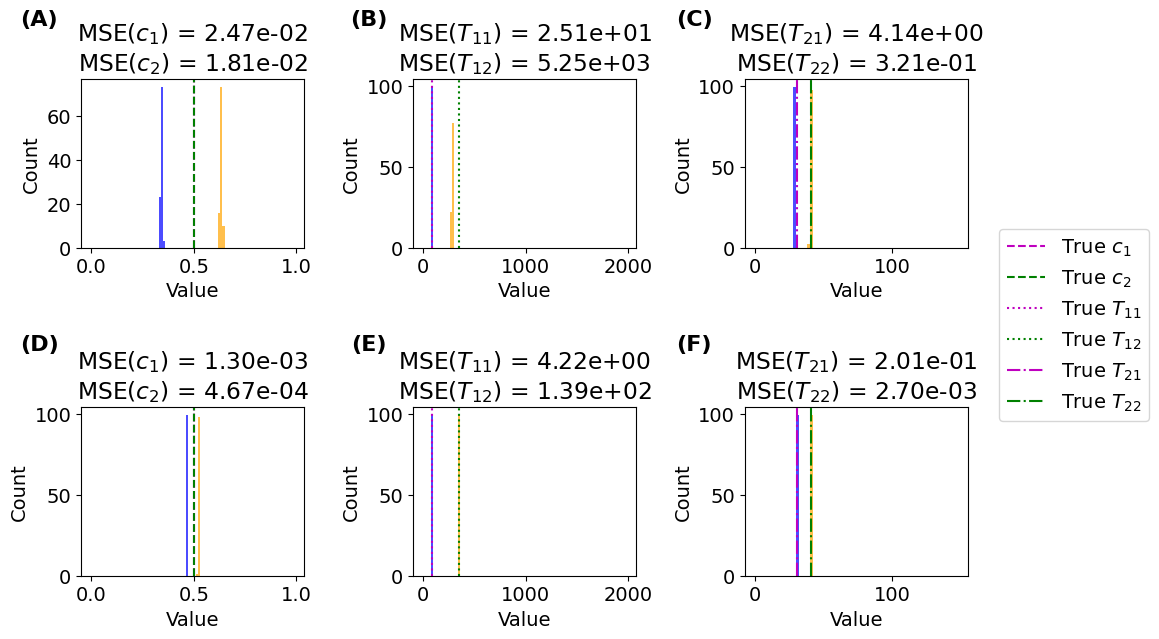

In [184]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(10, 6.5), tight_layout=True)
# fig.suptitle(f"Parameter Estimates at Specific Null Point Guess\nNull Point 1 = {np1_array[center1_ioi]} :: Null Point 2 = {np2_array[center2_ioi]}\n{var_reps} Iterations :: SNR = {SNR_array[SNR_index_oi] :0.2f}\n{ParamTitle_6p} = [{T11},{T12},{c1},{c2},{T21},{T21*T2rat_array[T2rat_index_oi]:.0f}]")

array_oi =conven_estimates_array

biasMat, stdMat, MSEMat = calc_MSE(array_oi, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[0,0].hist(x=array_oi[:,2], bins=bin_array, color='b', alpha = 0.7)
ax[0,0].hist(x=array_oi[:,3], bins=bin_array, color='orange', alpha = 0.7)
ax[0,0].axvline(x = true_params[2], label = r'True $c_{1}$', color='m', ls = '--')
ax[0,0].axvline(x = true_params[3], label = r'True $c_{2}$', color='g', ls = '--')
ax[0,0].set_xlabel('Value')
ax[0,0].set_ylabel('Count')
ax[0,0].set_title(f"MSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

xmin, xmax = ax[0,0].get_xlim()
ymin, ymax = ax[0,0].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[0,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[0,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[0,1].hist(x=array_oi[:,0], bins=bin_array, color='b', alpha = 0.7)
ax[0,1].hist(x=array_oi[:,1], bins=bin_array, color='orange', alpha = 0.7)
ax[0,1].axvline(x = true_params[0], label = r'True $T_{11}$', color='m', ls = ':')
ax[0,1].axvline(x = true_params[1], label = r'True $T_{12}$', color='g', ls = ':')
ax[0,1].set_xlabel('Value')
ax[0,1].set_ylabel('Count')
ax[0,1].set_title(f"MSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

xmin, xmax = ax[0,1].get_xlim()
ymin, ymax = ax[0,1].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[0,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[0,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[0,2].hist(x=array_oi[:,-2], bins=bin_array, color='b', alpha = 0.7)
ax[0,2].hist(x=array_oi[:,-1], bins=bin_array, color='orange', alpha = 0.7)
ax[0,2].axvline(x = true_params[-2], label = r'True $T_{21}$', color='m', ls = '-.')
ax[0,2].axvline(x = true_params[-1], label = r'True $T_{22}$', color='g', ls = '-.')
ax[0,2].set_xlabel('Value')
ax[0,2].set_ylabel('Count')
ax[0,2].set_title(f"MSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

xmin, xmax = ax[0,2].get_xlim()
ymin, ymax = ax[0,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[0,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[0,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')

array_oi = COFFEE_estimates_array

biasMat, stdMat, MSEMat = calc_MSE(array_oi, true_params)

bin_array = np.arange(0, 1, 0.01)
ax[1,0].hist(x=array_oi[:,2], bins=bin_array, color='b', alpha = 0.7)
ax[1,0].hist(x=array_oi[:,3], bins=bin_array, color='orange', alpha = 0.7)
ax[1,0].axvline(x = true_params[2], color='m', ls = '--')
ax[1,0].axvline(x = true_params[3], color='g', ls = '--')
ax[1,0].set_xlabel('Value')
ax[1,0].set_ylabel('Count')
ax[1,0].set_title(f"\nMSE({ParamTitle_6p[-4]}) = {MSEMat[-4]:.2e}\nMSE({ParamTitle_6p[-3]}) = {MSEMat[-3]:.2e}")

ymin, ymax = ax[1,0].get_ylim()
xmin, xmax = ax[1,0].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
# ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

bin_array = np.arange(0, 2000, 20)
ax[1,1].hist(x=array_oi[:,0], bins=bin_array, color='b', alpha = 0.7)
ax[1,1].hist(x=array_oi[:,1], bins=bin_array, color='orange', alpha = 0.7)
ax[1,1].axvline(x = true_params[0], color='m', ls = ':')
ax[1,1].axvline(x = true_params[1], color='g', ls = ':')
ax[1,1].set_xlabel('Value')
ax[1,1].set_ylabel('Count')
ax[1,1].set_title(f"MSE({ParamTitle_6p[0]}) = {MSEMat[0]:.2e}\nMSE({ParamTitle_6p[1]}) = {MSEMat[1]:.2e}")

ymin, ymax = ax[1,1].get_ylim()
xmin, xmax = ax[1,1].get_xlim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[1,1].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[0]}): {MSEMat[0] :0.2e}", color = 'k')
# ax[1,1].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[1]}): {MSEMat[1] :0.2e}", color = 'k')

bin_array = np.arange(0, 150, 2)
ax[1,2].hist(x=array_oi[:,-2], bins=bin_array, color='b', alpha = 0.7)
ax[1,2].hist(x=array_oi[:,-1], bins=bin_array, color='orange', alpha = 0.7)
ax[1,2].axvline(x = true_params[-2], color='m', ls = '-.')
ax[1,2].axvline(x = true_params[-1], color='g', ls = '-.')
ax[1,2].set_xlabel('Value')
ax[1,2].set_ylabel('Count')
ax[1,2].set_title(f"\nMSE({ParamTitle_6p[-2]}) = {MSEMat[-2]:.2e}\nMSE({ParamTitle_6p[-1]}) = {MSEMat[-1]:.2e}")

xmin, xmax = ax[1,2].get_xlim()
ymin, ymax = ax[1,2].get_ylim()
yup = ymin+(ymax-ymin)*2//3
ydn = ymin+(ymax-ymin)*1//3
# ax[1,2].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-2]}): {MSEMat[-2] :0.2e}", color = 'k')
# ax[1,2].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-1]}): {MSEMat[-1] :0.2e}", color = 'k')




fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.rc('font', size = 16)
fig.text(0.05,0.97, '(A)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.97, '(B)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.97, '(C)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.05,0.47, '(D)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.38,0.47, '(E)', ha="center", va="center", color="black", weight = "bold")
fig.text(0.705,0.47, '(F)', ha="center", va="center", color="black", weight = "bold")
plt.rc('font', size = 14)

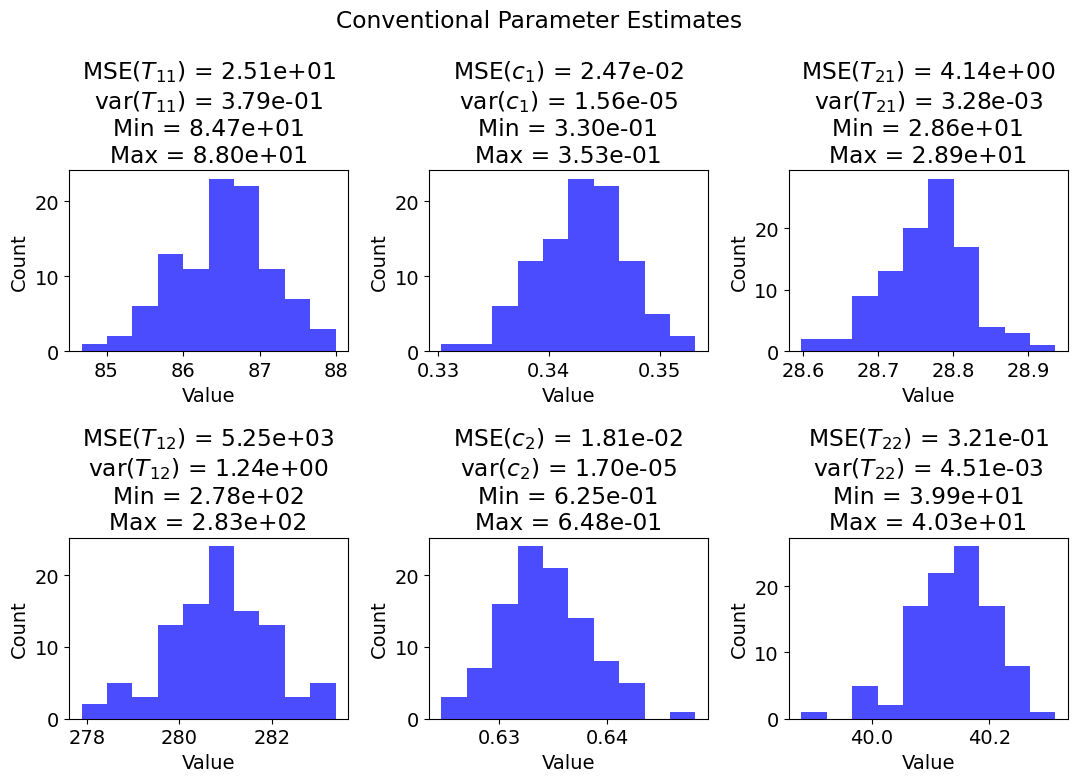

In [187]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(11, 8), tight_layout=True)
fig.suptitle(f"Conventional Parameter Estimates")

array_oi = conven_estimates_array
biasMat, stdMat, MSEMat = calc_MSE(conven_estimates_array, true_params)

for i in range(array_oi.shape[-1]):

    # bin_array = np.arange(0, 1, 0.01)
    ax[i%2, i//2].hist(x=array_oi[:,i], color='b', alpha = 0.7)
    # ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
    ax[i%2, i//2].set_xlabel('Value')
    ax[i%2, i//2].set_ylabel('Count')
    ax[i%2, i//2].set_title(f"MSE({ParamTitle_6p[i]}) = {MSEMat[i]:.2e}\nvar({ParamTitle_6p[i]}) = {stdMat[i]**2:.2e}\nMin = {np.min(array_oi[:,i]):.2e}\nMax = {np.max(array_oi[:,i]):.2e}")

    ymin, ymax = ax[i%2, i//2].get_ylim()
    xmin, xmax = ax[i%2, i//2].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')

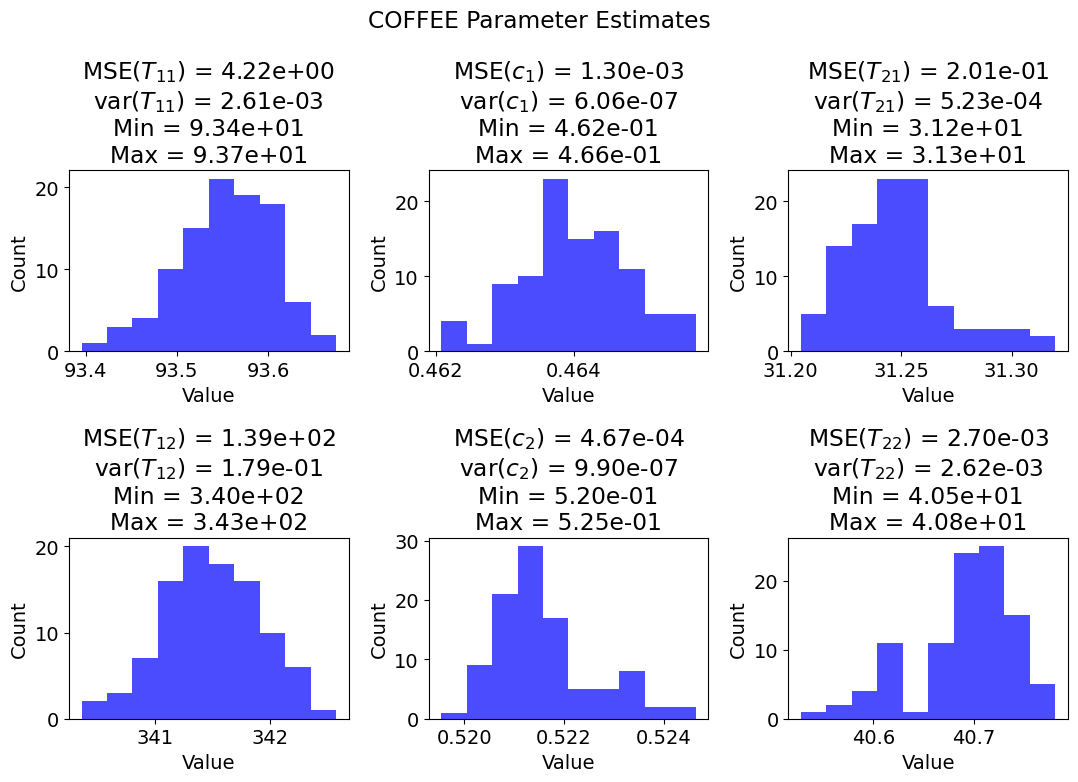

In [188]:
plt.rc('font', size = 14)

fig, ax = plt.subplots(2, 3, figsize=(11, 8), tight_layout=True)
fig.suptitle(f"COFFEE Parameter Estimates")

array_oi = COFFEE_estimates_array

biasMat, stdMat, MSEMat = calc_MSE(array_oi, true_params)

for i in range(array_oi.shape[-1]):

    # bin_array = np.arange(0, 1, 0.01)
    ax[i%2, i//2].hist(x=array_oi[:,i], color='b', alpha = 0.7)
    # ax[i%2, i//2].axvline(x = true_params[i], color='m', ls = '--')
    ax[i%2, i//2].set_xlabel('Value')
    ax[i%2, i//2].set_ylabel('Count')
    ax[i%2, i//2].set_title(f"MSE({ParamTitle_6p[i]}) = {MSEMat[i]:.2e}\nvar({ParamTitle_6p[i]}) = {stdMat[i]**2:.2e}\nMin = {np.min(array_oi[:,i]):.2e}\nMax = {np.max(array_oi[:,i]):.2e}")

    ymin, ymax = ax[i%2, i//2].get_ylim()
    xmin, xmax = ax[i%2, i//2].get_xlim()
    yup = ymin+(ymax-ymin)*2//3
    ydn = ymin+(ymax-ymin)*1//3
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, yup, f"MSE({ParamTitle_6p[-4]}): {MSEMat[-4] :0.2e}", color = 'k')
    # ax[1,0].text(xmin+(xmax-xmin)*0.1, ydn, f"MSE({ParamTitle_6p[-3]}): {MSEMat[-3] :0.2e}", color = 'k')